In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import svox
import svox_renderer
import torch
import matplotlib.pyplot as plt
import math
import numpy as np

In [11]:
device = 'cpu'
t = svox.N3Tree.load("lego.npz", device=device)

In [14]:
r = svox_renderer.VolumeRenderer(t)

[autoreload of svox_renderer failed: Traceback (most recent call last):
  File "/home/giacomo/miniconda3/envs/torch/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/giacomo/miniconda3/envs/torch/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/giacomo/miniconda3/envs/torch/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/giacomo/miniconda3/envs/torch/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/giacomo/miniconda3/envs/torch/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/giacomo/miniconda3/envs/torch/lib/python3.9/site-packages/IPython/extensions/autoreload

/home/giacomo/Dropbox/unige/plenoxels/svox_renderer.py:219: UserWarning: Using slow volume rendering, should only be used for debugging
  warn("Using slow volume rendering, should only be used for debugging")


light intensity torch.Size([640000])
out_rgb torch.Size([640000, 3])
bg 1.0


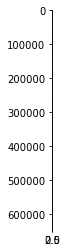

In [15]:
# Matrix copied from lego test set image 0
c2w = torch.tensor([[ -0.9999999403953552, 0.0, 0.0, 0.0 ],
                    [ 0.0, -0.7341099977493286, 0.6790305972099304, 2.737260103225708 ],
                    [ 0.0, 0.6790306568145752, 0.7341098785400391, 2.959291696548462 ],
                    [ 0.0, 0.0, 0.0, 1.0 ],
             ], device=device)

with torch.no_grad():
    im = r.render_persp(c2w, height=800, width=800, fx=1111.111).clamp_(0.0, 1.0)
plt.imshow(im.cpu())
plt.show()

## Experiments on DDA Intersection

In [4]:
def dda_unit(center, invdir):
    t1 = - center * invdir
    t2 = t1 + invdir
    tmin = np.amax(np.minimum(t1, t2))
    tmax = np.amin(np.maximum(t1, t2))
    return tmin, tmax

In [147]:
d = np.array([1.9, 1.5])
o = np.array([0.9, 0.1])
d = d / np.linalg.norm(d)
invd = 1 / d
t = 1.4

In [149]:
from matplotlib import patches

Pos [1.21395311 0.34785772]
subcube -0.40000000000000013 0.08414873747640825
Subcube size 0.4841487374764084
dt 0.2420743687382042



Pos [1.40395311 0.49785772]
subcube -0.6420743687382042 -0.15792563126179607
Subcube size 0.4841487374764082
dt 0.2420743687382041



Pos [1.59395311 0.64785772]
subcube -0.8841487374764082 -0.4
Subcube size 0.4841487374764082
dt 0.2420743687382041





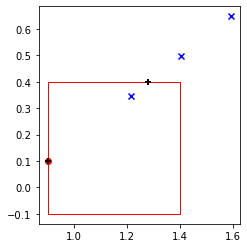

In [160]:
fig, ax = plt.subplots()
ax.scatter(o[0], o[1], marker='o', color='r')
t = 0.4
for i in range(3):
    pos = o + t * d
    print("Pos", pos)
    ax.scatter(pos[0], pos[1], marker='x', color='b')
    
    aabb = np.array([[0.9, -0.1], [1.4, 0.]])
    t1 = (aabb[1] - pos) / d
    t2 = (aabb[0] - pos) / d
    subcube_tmin = np.amax(np.minimum(t1, t2))
    subcube_tmax = np.amin(np.maximum(t1, t2))

#     ax.plot([pos[0], pos[0] + (subcube_tmax - subcube_tmin)], [pos[1], pos[1]])
    print("subcube", subcube_tmin, subcube_tmax)
    print("Subcube size", subcube_tmax - subcube_tmin)
    
    rect = patches.Rectangle(aabb[0], (aabb[1] - aabb[0])[0], (aabb[1] - aabb[0])[1], 
                             edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.scatter((pos + subcube_tmin * d)[0], (pos + subcube_tmin * d)[1], marker='+', color='k')
    ax.scatter((pos + subcube_tmax * d)[0], (pos + subcube_tmax * d)[1], marker='+', color='k')
    dt = (subcube_tmax - subcube_tmin) / 2
    print("dt", dt)
    print("\n\n")
    t += dt
ax.set_aspect('equal')

## Test interpolation

TODO List:
 - [x] Newton iteration for interpolation
 - [x] Implement parent-sum for queries and set
 - [ ] CUDA

### Helper functions

In [1728]:
def pack_index(txy, N=2):
    return txy[:, 0] * (N ** 2) + txy[:, 1] * N + txy[:, 2]

def unpack_index(flat, N=2):
    t = []
    for i in range(2):
        t.append(flat % N)
        flat.div_(N, rounding_mode='floor')
    return torch.stack((flat, t[1], t[0]), dim=-1).long()

def cross(a, b):
    return a[:, 0] * b[:, 1] - a[:, 1] * b[:, 0]
# Interpolation
# https://stackoverflow.com/questions/808441/inverse-bilinear-interpolation

In [ ]:
def interp_2d_quad_weights_newt(n_coo,   # n, 4, 2
                                p_coo):  # n, 2
    # https://stackoverflow.com/questions/808441/inverse-bilinear-interpolation
    n_iter = 3
    n = n_coo.shape[0]
    st = torch.full((2, n), 0.45, dtype=torch.float32).T  # make the columns contiguous
    s, t = st[:, 0].unsqueeze(1), st[:, 1].unsqueeze(1)   # n, 1
    for i in range(n_iter):
        r = n_coo[:, 0] * (1 - s) * (1 - t) + \
            n_coo[:, 1] * s       * (1 - t) + \
            n_coo[:, 2] * (1 - s) * t       + \
            n_coo[:, 3] * t       * s       - p_coo      # n, 2
        jxy1 = (1 - t) * (-n_coo[:, 0] + n_coo[:, 1]) + t * (-n_coo[:, 2] + n_coo[:, 3])  # n, 2  dr/ds
        jxy2 = (1 - s) * (-n_coo[:, 0] + n_coo[:, 2]) + s * (-n_coo[:, 1] + n_coo[:, 3])  # n, 2  dr/dt

        inv_det_j = 1/(jxy1[:, 0] * jxy2[:, 1] - jxy2[:, 0] * jxy1[:, 1])
        inv_det_j = inv_det_j.unsqueeze(-1)
        
        s = s - inv_det_j * ( jxy2[:, 1] * r[:, 0] - jxy2[:, 0] * r[:, 1]).unsqueeze(-1)
        t = t - inv_det_j * (-jxy1[:, 1] * r[:, 0] + jxy1[:, 0] * r[:, 1]).unsqueeze(-1)
    weights = torch.cat((
        (1 - t) * (1 - s),
        (1 - t) * s,
        t * (1 - s),
        t * s,
    ), dim=1)#.clamp_(0, 1)
    return weights

In [ ]:
def interp_2d_quad_weights(n_coo,  # n, 4, 2
                           p_coo,         # n, 2
                           ):
    # https://stackoverflow.com/questions/808441/inverse-bilinear-interpolation
    # p0 = 2      0
    # p1 = 3      1
    # p2 = 0      2
    # p3 = 1      3
    # s between p0, p1 -- t between p0, p2
    a = n_coo[:, 0] - p_coo         # p0 - p
    b = n_coo[:, 0] - n_coo[:, 2]   # p0 - p2
    c = n_coo[:, 1] - n_coo[:, 3]   # p1 - p3
    d = n_coo[:, 1] - p_coo         # p1 - p
    A = cross(a, b)                      # (p0 - p) x (p0 - p2)
    B = (cross(a, c) + cross(d, b)) / 2  # [(p0 - p) x (p1 - p3) + (p1 - p) x (p0 - p2)] / 2
    C = cross(d, c)                      # (p1 - p) x (p1 - p3)
    quad_den = A - 2 * B + C
    use_lin = torch.abs(quad_den) < 1e-6
    s = torch.empty_like(C)
    s[use_lin] = (A[use_lin] / (A[use_lin] - C[use_lin]))
    s[~use_lin] = (((A - B) + torch.sqrt(B**2 - A*C)) / quad_den)[~use_lin]
    need_other_f = (s[~use_lin] < 0) | (s[~use_lin] > 1)
    s[~use_lin][need_other_f] = (((A - B) - torch.sqrt(B**2 - A*C)) / quad_den)[~use_lin][need_other_f]
    t = ((1 - s) * a[:, 0] + s * d[:, 0]) / ((1 - s) * b[:, 0] + s * c[:, 0])
    weights = torch.stack((
        (1 - t) * (1 - s),
        (1 - t) * s,
        t * (1 - s),
        t * s,
    ), dim=1)
    return weights

### Experiment runner with fox image

In [2215]:
def run_exp(upsmpl, levels, N, elim_sliver=3, parent_sum=True):
    from scipy import misc
    f = misc.face()
    f = f[100:300, 300:500, 0]
    f = f / 255.
    tree = Tree2D(levels=levels, data_dim=1, N=N, parent_sum=parent_sum)
    x = np.arange(f.shape[0]) / f.shape[0]
    y = np.arange(f.shape[1]) / f.shape[1]
    X, Y = np.meshgrid(x, y)
    indices = torch.from_numpy(np.stack((X.ravel(), Y.ravel()), 1)).float()
    values = torch.from_numpy(f.ravel()).float().unsqueeze(-1).float()
    
    tree.set(indices, values)
    
    x = np.arange(f.shape[0] * upsmpl) / f.shape[0] / upsmpl
    y = np.arange(f.shape[1] * upsmpl) / f.shape[1] / upsmpl
    X, Y = np.meshgrid(x, y)
    indices = torch.from_numpy(np.stack((X.ravel(), Y.ravel()), 1)).float()
    
    f_upsmpl_true = torch.nn.functional.interpolate(
        torch.from_numpy(f).float().unsqueeze(0).unsqueeze(0), size=f.shape[0] * upsmpl,
        mode='bilinear').squeeze()
    f_upsmpl_true = f_upsmpl_true[elim_sliver:-elim_sliver, elim_sliver:-elim_sliver]
    
    f_upsmpl = tree.query_interp(indices)
    f_upsmpl = f_upsmpl.reshape(f.shape[0] * upsmpl, f.shape[1] * upsmpl)
    f_upsmpl = f_upsmpl[elim_sliver:-elim_sliver, elim_sliver:-elim_sliver]
    
    f_upsmpl_old = tree.query(indices)
    f_upsmpl_old = f_upsmpl_old.reshape(f.shape[0] * upsmpl, f.shape[1] * upsmpl)
    f_upsmpl_old = f_upsmpl_old[elim_sliver:-elim_sliver, elim_sliver:-elim_sliver]
    
    mse_query = torch.mean((f_upsmpl_old - f_upsmpl_true) ** 2)
    psnr_query = -10.0 * torch.log(mse_query) / math.log(10)
    
    mse_interp = torch.mean((f_upsmpl - f_upsmpl_true) ** 2)
    psnr_interp = -10.0 * torch.log(mse_interp) / math.log(10)
    
    fig, ax = plt.subplots(ncols=3, figsize=(8, 4))
    ax[0].imshow(f_upsmpl_true, vmin=0, vmax=1)
    ax[1].imshow(f_upsmpl_old, vmin=0, vmax=1)
    ax[1].set_title("PSNR: %.4f" % (psnr_query))
    ax[2].imshow(f_upsmpl, vmin=0, vmax=1)
    ax[2].set_title("PSNR: %.4f" % (psnr_interp))
    return tree

### Test tree definitions

In [2071]:
class Tree2D():
    def __init__(self, levels: int, data_dim: int, N: int, parent_sum: bool):
        self.N = N
        self.data_dim = data_dim
        self.data = torch.zeros(1, data_dim)
        self.child = torch.zeros(0, self.N, self.N, dtype=torch.int32)
        self.is_child_leaf = torch.ones(0, self.N, self.N, dtype=torch.bool)
        self.parent_depth = torch.zeros(1, 2, dtype=torch.int32)
        self.n_internal = 1
        self.parent_sum = parent_sum
        for i in range(levels):
            self.refine()

In [2072]:
def refine(tree, leaves=None):
    n_internal = tree.child.shape[0]
    filled = tree.data.shape[0]
    if leaves is None:
        leaves = (tree.is_child_leaf).nonzero(as_tuple=False)
    leaf_shape = tree.child.shape[1:]
    if tree.data.shape[0] == 1:  # root node is an exception
        leaves = torch.tensor([[0, 0, 0]])
        n_new_parents = 1
        new_filled = filled + n_new_parents * (tree.N ** 2)
        resize_add_cap(tree, n_new_parents)

        new_child_ids = torch.arange(filled, new_filled, dtype=torch.int32)
        tree.child[:] = new_child_ids.reshape(-1, tree.N, tree.N)
        tree.is_child_leaf[leaves[:, 0], leaves[:, 1], leaves[:, 2]] = True
        tree.parent_depth[filled:new_filled, 0] = 0
        tree.parent_depth[filled:new_filled, 1] = 1
    else:
        n_new_parents = leaves.shape[0]
        new_filled = filled + n_new_parents * (tree.N ** 2)
        resize_add_cap(tree, n_new_parents)
        new_child_ids = torch.arange(filled, new_filled, dtype=torch.int32)
        tree.child[n_internal:n_internal + n_new_parents] = \
            new_child_ids.reshape(-1, tree.N, tree.N) - \
            torch.arange(n_internal, n_internal + n_new_parents).view(-1, 1, 1)
        tree.is_child_leaf[leaves[:, 0], leaves[:, 1], leaves[:, 2]] = False
        tree.parent_depth[filled:new_filled, 0] = pack_index(leaves, tree.N).repeat_interleave(tree.N ** 2) + 1
        tree.parent_depth[filled:new_filled, 1] = tree.parent_depth[
            pack_index(leaves, tree.N).repeat_interleave(tree.N ** 2) + 1, 1] + 1

def resize_add_cap(tree, new_parents):
    leaf_shape = tree.child.shape[1:]
    tree.child = torch.cat((
        tree.child,
        torch.zeros((new_parents, *leaf_shape), dtype=tree.child.dtype)))
    tree.data = torch.cat((
        tree.data,
        torch.zeros((new_parents * np.prod(leaf_shape), tree.data.shape[-1]), dtype=tree.data.dtype)
    ))
    tree.is_child_leaf = torch.cat((
        tree.is_child_leaf,
        torch.ones((new_parents, *leaf_shape), dtype=tree.is_child_leaf.dtype)
    ))
    tree.parent_depth = torch.cat((
        tree.parent_depth,
        torch.zeros((new_parents * np.prod(leaf_shape), tree.parent_depth.shape[-1]), dtype=tree.parent_depth.dtype)
    ))

In [2074]:
tree = Tree2D(0, 1, 3, parent_sum=True)
refine(tree)
refine(tree)

In [2104]:
def set(tree, indices, values):
    n = indices.shape[0]
    indices.clamp_(0.0, 1.0 - 1e-10)
    ind = indices.clone()

    node_ids = torch.zeros(n, dtype=torch.long)
    remain_mask = torch.ones(n, dtype=torch.bool)
    while remain_mask.any():
        ind_floor = torch.floor(ind[remain_mask] * tree.N)
        ind_floor.clamp_max_(tree.N - 1)
        sel = (node_ids[remain_mask], *(ind_floor.long().T),)
        deltas = tree.child[sel]
        data_sel = (deltas + node_ids[remain_mask]).view(-1)
        
        nonterm_partial_mask = ~tree.is_child_leaf[sel]
        nonterm_mask = torch.zeros(n, dtype=torch.bool)
        nonterm_mask[remain_mask] = nonterm_partial_mask

        node_ids[remain_mask] += deltas
        ind[remain_mask] = ind[remain_mask] * tree.N - ind_floor

        vals = tree.data[data_sel]

        term_mask = remain_mask & ~nonterm_mask
        vals[~nonterm_partial_mask.view(-1)] = values[term_mask]
        tree.data[data_sel] = vals

        remain_mask &= nonterm_mask
    # Set all parents to be their child's average (bottom to top)
    # Remove the average from the children
    max_depth = tree.parent_depth[:, 1].max()
    for depth in range(max_depth, 0, -1):
        child_idx = (tree.parent_depth[:, 1] == depth).nonzero().squeeze()
        parent_idx = tree.parent_depth[child_idx, 0].long()
        tree.data[parent_idx].fill_(0)
        tree.data.scatter_add_(0, parent_idx.unsqueeze(-1), tree.data[child_idx])
        tree.data[parent_idx] /= tree.N ** 2
        if tree.parent_sum:
            tree.data.scatter_add_(0, child_idx.unsqueeze(-1), -tree.data[parent_idx])

In [2155]:
tree = Tree2D(0, 1, 3, parent_sum=True)
refine(tree)
refine(tree)
set(tree, torch.tensor([[0.3, 0.3], [0.3, 0.5], [0.5, 0.5], [0.5, 0.3], [0.8, 0.6]]), 
    torch.tensor([[1.], [1.], [0.5], [0.5], [2.3]]))

In [2147]:
def query(tree, indices):
    n = indices.shape[0]

    node_ids = torch.zeros(n, dtype=torch.long)
    remain_indices = torch.arange(n, dtype=torch.long)
    result = torch.zeros((n, tree.data_dim), dtype=tree.data.dtype)
    if tree.parent_sum:
        result += tree.data[0].unsqueeze(0)
    xy = indices.clone()
    while remain_indices.numel():
        xy *= tree.N
        xy_floor = torch.floor(xy)
        xy_floor.clamp_max_(tree.N - 1)
        xy -= xy_floor
        sel = (node_ids[remain_indices], *(xy_floor.long().T),)
        deltas = tree.child[sel]
        data_sel = (deltas + node_ids[remain_indices]).view(-1)

        term_mask = tree.is_child_leaf[sel]  # terminate when nodes with 0 children encountered (leaves).
        term_indices = remain_indices[term_mask]

        vals = tree.data[data_sel]
        if tree.parent_sum:
            result[remain_indices] += vals
        else:
            result[term_indices] = vals[term_mask.view(-1)]

        node_ids[remain_indices] += deltas
        remain_indices = remain_indices[~term_mask]
        xy = xy[~term_mask]

    return result

In [2202]:
def query_interp(tree, indices):  # indices: n, 2
    n = indices.shape[0]
    neighbor_offsets = torch.tensor([[-1, -1], [-1, 0], [0, -1], [0, 0]], dtype=torch.int32)
    neighbor_offsets2 = torch.tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]], dtype=torch.int32)

    neighbor_vals = torch.zeros(n, 4, tree.data_dim)
    neighbor_coo = (neighbor_offsets + 1).repeat(n, 1, 1).float()  # n, 4, 2

    node_ids = torch.zeros(n, dtype=torch.long)
    remain_indices = torch.arange(n, dtype=torch.long)
    result = torch.zeros((n, tree.data_dim), dtype=tree.data.dtype)
    if tree.parent_sum:
        result += tree.data[0].unsqueeze(0)
    xy = indices.clone()
    cube_sz = tree.N

    while remain_indices.numel():
        xy *= tree.N
        xy_floor = torch.floor(xy).clamp_max_(tree.N - 1)
        xy -= xy_floor
        xyc = xy * 2
        xyc_floor = torch.floor(xyc).clamp_max_(1)
        xyc -= xyc_floor
        if n == 1:
            print("xy", xy, xy_floor)
            print("xyc", xyc, xyc_floor)

        neighbor_ids = (xyc_floor + xy_floor).unsqueeze(1) + neighbor_offsets.unsqueeze(0) # n, 4, 2
        valid_neighbors = ((neighbor_ids >= 0) & (neighbor_ids < tree.N)).all(-1)  # n, 4
        neigh_ids_flat = neighbor_ids.view(-1, 2).long()  # n * 4, 2
        neighbor_sel = (
            node_ids[remain_indices].repeat_interleave(4),
            neigh_ids_flat[:, 0].clamp(0, tree.N - 1),
            neigh_ids_flat[:, 1].clamp(0, tree.N - 1),
        )
        neighbor_deltas = tree.child[neighbor_sel]
        neighbor_data_sel = (neighbor_deltas + neighbor_sel[0])[valid_neighbors.view(-1)]

        neighbor_data = tree.data[neighbor_data_sel]
        neighbor_vals[valid_neighbors] = neighbor_data
        
        nxt_cube_sz = cube_sz * tree.N
        neighbors = indices[remain_indices].unsqueeze(1) + \
                        neighbor_offsets2.unsqueeze(0) / (cube_sz * 2) # n, 4, 2
        neighbor_centers = (torch.floor(neighbors * cube_sz + 1e-5) + 0.5)#1 / tree.N)
        neighbor_centers = torch.clamp(neighbor_centers / cube_sz, min=1/nxt_cube_sz, max=1-(1/nxt_cube_sz))
        neighbor_coo[valid_neighbors] = neighbor_centers[valid_neighbors]

        # Some points terminate at this level.
        sel = (node_ids[remain_indices], *(xy_floor.long().T),)
        term_mask = tree.is_child_leaf[sel]
        term_indices = remain_indices[term_mask]
        
        weights = interp_2d_quad_weights(neighbor_coo[term_mask], indices[term_indices])

        if tree.parent_sum:
            deltas = tree.child[sel]
            data_sel = (deltas + sel[0]).view(-1)
            vals = tree.data[data_sel]
            result[~term_mask] += vals[~term_mask]
        
        result[term_indices] = (
            neighbor_vals[term_mask] * weights.unsqueeze(-1)
        ).sum(1)[term_indices]

        deltas = tree.child[sel]
        node_ids[remain_indices] += deltas
        neighbor_vals = neighbor_vals[~term_mask]
        remain_indices = remain_indices[~term_mask]
        neighbor_coo = neighbor_coo[~term_mask]
        cube_sz *= tree.N
        xy = xy[~term_mask]
        if n == 1:
            print()
    return result

In [2203]:
tree = Tree2D(0, 1, N=3, parent_sum=True)
refine(tree)
refine(tree)
set(tree, torch.tensor([[0.3, 0.3], [0.3, 0.5], [0.5, 0.5], [0.5, 0.3]]), 
    torch.tensor([[1.], [1.], [0.5], [0.5]]))

In [2204]:
query_interp(tree, torch.tensor([[0.25, 0.25]]))

xy tensor([[0.7500, 0.7500]]) tensor([[0., 0.]])
xyc tensor([[0.5000, 0.5000]]) tensor([[1., 1.]])

xy tensor([[0.2500, 0.2500]]) tensor([[2., 2.]])
xyc tensor([[0.5000, 0.5000]]) tensor([[0., 0.]])



tensor([[0.4514]])

In [2205]:
query(tree, torch.tensor([[0.32, 0.32]]))

tensor([[1.]])

In [2212]:
tree = Tree2D(0, 1, N=4, parent_sum=True)
refine(tree)
refine(tree)
set(tree, torch.tensor([[0.3, 0.3], [0.3, 0.5], [0.5, 0.5], [0.5, 0.3]]), 
    torch.tensor([[1.], [1.], [0.5], [0.5]]))
# query_interp(tree, torch.tensor([[0.125, 0.125]]))
query_interp(tree, torch.tensor([[0.1, 0.1]]))

xy tensor([[0.4000, 0.4000]]) tensor([[0., 0.]])
xyc tensor([[0.8000, 0.8000]]) tensor([[0., 0.]])

xy tensor([[0.6000, 0.6000]]) tensor([[1., 1.]])
xyc tensor([[0.2000, 0.2000]]) tensor([[1., 1.]])



tensor([[0.]])

In [2213]:
resx, resy = 128, 128
x = np.arange(resx) / resx
y = np.arange(resy) / resy
X, Y = np.meshgrid(x, y)
indices = torch.from_numpy(np.stack((X.ravel(), Y.ravel()), 1)).float()
print(indices)
f_upsmpl = query_interp(tree, indices).reshape(resx, resy)
print(f_upsmpl)
f_upsmpl_old = query(tree, indices).reshape(resx, resy)
fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
ax[0].imshow(f_upsmpl_old, vmin=0, vmax=1)
ax[1].imshow(f_upsmpl, vmin=0, vmax=1)

tensor([[0.0000, 0.0000],
        [0.0078, 0.0000],
        [0.0156, 0.0000],
        ...,
        [0.9766, 0.9922],
        [0.9844, 0.9922],
        [0.9922, 0.9922]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


<IPython.core.display.Javascript object>

### Real tree experiments

In [2464]:
class Tree2D():
    def __init__(self, levels: int, data_dim: int, N: int, parent_sum: bool):
        self.N = N
        self.data_dim = data_dim
        self.data = torch.zeros(1, data_dim)
        self.child = torch.zeros(0, self.N, self.N, dtype=torch.int32)
        self.is_child_leaf = torch.ones(0, self.N, self.N, dtype=torch.bool)
        self.parent_depth = torch.zeros(1, 2, dtype=torch.int32)
        self.n_internal = 1
        self.parent_sum = parent_sum
        for i in range(levels):
            self.refine()
            
    def refine(tree, leaves=None):
        n_internal = tree.child.shape[0]
        filled = tree.data.shape[0]
        if leaves is None:
            leaves = (tree.is_child_leaf).nonzero(as_tuple=False)
        if tree.data.shape[0] == 1:  # root node is an exception
            leaves = torch.tensor([[0, 0, 0]])
            n_new_parents = 1
            new_filled = filled + n_new_parents * (tree.N ** 2)
            tree.resize_add_cap(n_new_parents)

            new_child_ids = torch.arange(filled, new_filled, dtype=torch.int32)
            tree.child[:] = new_child_ids.reshape(-1, tree.N, tree.N)
            tree.is_child_leaf[leaves[:, 0], leaves[:, 1], leaves[:, 2]] = True
            tree.parent_depth[filled:new_filled, 0] = 0
            tree.parent_depth[filled:new_filled, 1] = 1
        else:
            n_new_parents = leaves.shape[0]
            new_filled = filled + n_new_parents * (tree.N ** 2)
            tree.resize_add_cap(n_new_parents)
            new_child_ids = torch.arange(filled, new_filled, dtype=torch.int32)
            tree.child[n_internal:n_internal + n_new_parents] = \
                new_child_ids.reshape(-1, tree.N, tree.N) - \
                torch.arange(n_internal, n_internal + n_new_parents).view(-1, 1, 1)
            tree.is_child_leaf[leaves[:, 0], leaves[:, 1], leaves[:, 2]] = False
            tree.parent_depth[filled:new_filled, 0] = pack_index(leaves, tree.N).repeat_interleave(tree.N ** 2) + 1
            tree.parent_depth[filled:new_filled, 1] = tree.parent_depth[
                pack_index(leaves, tree.N).repeat_interleave(tree.N ** 2) + 1, 1] + 1

    def resize_add_cap(tree, new_parents):
        leaf_shape = tree.child.shape[1:]
        tree.child = torch.cat((
            tree.child,
            torch.zeros((new_parents, *leaf_shape), dtype=tree.child.dtype)))
        tree.data = torch.cat((
            tree.data,
            torch.zeros((new_parents * np.prod(leaf_shape), tree.data.shape[-1]), dtype=tree.data.dtype)
        ))
        tree.is_child_leaf = torch.cat((
            tree.is_child_leaf,
            torch.ones((new_parents, *leaf_shape), dtype=tree.is_child_leaf.dtype)
        ))
        tree.parent_depth = torch.cat((
            tree.parent_depth,
            torch.zeros((new_parents * np.prod(leaf_shape), tree.parent_depth.shape[-1]), dtype=tree.parent_depth.dtype)
        ))
    
    def set(tree, indices, values):
        n = indices.shape[0]
        indices.clamp_(0.0, 1.0 - 1e-10)
        ind = indices.clone()

        node_ids = torch.zeros(n, dtype=torch.long)
        remain_mask = torch.ones(n, dtype=torch.bool)
        while remain_mask.any():
            ind_floor = torch.floor(ind[remain_mask] * tree.N)
            ind_floor.clamp_max_(tree.N - 1)
            sel = (node_ids[remain_mask], *(ind_floor.long().T),)
            deltas = tree.child[sel]
            data_sel = (deltas + node_ids[remain_mask]).view(-1)

            nonterm_partial_mask = ~tree.is_child_leaf[sel]
            nonterm_mask = torch.zeros(n, dtype=torch.bool)
            nonterm_mask[remain_mask] = nonterm_partial_mask

            node_ids[remain_mask] += deltas
            ind[remain_mask] = ind[remain_mask] * tree.N - ind_floor

            vals = tree.data[data_sel]

            term_mask = remain_mask & ~nonterm_mask
            vals[~nonterm_partial_mask.view(-1)] = values[term_mask]
            tree.data[data_sel] = vals

            remain_mask &= nonterm_mask
        # Set all parents to be their child's average (bottom to top)
        # Remove the average from the children
        max_depth = tree.parent_depth[:, 1].max()
        for depth in range(max_depth, 0, -1):
            child_idx = (tree.parent_depth[:, 1] == depth).nonzero().squeeze()
            parent_idx = tree.parent_depth[child_idx, 0].long()
            tree.data[parent_idx].fill_(0)
            tree.data.scatter_add_(
                0, 
                parent_idx.unsqueeze(-1).expand(parent_idx.shape[0], tree.data_dim), 
                tree.data[child_idx]
            )
            tree.data[parent_idx] /= tree.N ** 2
            if tree.parent_sum:
                tree.data.scatter_add_(
                    0, 
                    child_idx.unsqueeze(-1).expand(child_idx.shape[0], tree.data_dim), 
                    -tree.data[parent_idx])
            
    def query(tree, indices):
        n = indices.shape[0]

        node_ids = torch.zeros(n, dtype=torch.long)
        remain_indices = torch.arange(n, dtype=torch.long)
        result = torch.zeros((n, tree.data_dim), dtype=tree.data.dtype)
        if tree.parent_sum:
            result += tree.data[0].unsqueeze(0)
        xy = indices.clone()
        while remain_indices.numel():
            xy *= tree.N
            xy_floor = torch.floor(xy)
            xy_floor.clamp_max_(tree.N - 1)
            xy -= xy_floor
            sel = (node_ids[remain_indices], *(xy_floor.long().T),)
            deltas = tree.child[sel]
            data_sel = (deltas + node_ids[remain_indices]).view(-1)

            term_mask = tree.is_child_leaf[sel]  # terminate when nodes with 0 children encountered (leaves).
            term_indices = remain_indices[term_mask]

            vals = tree.data[data_sel]
            if tree.parent_sum:
                result[remain_indices] += vals
            else:
                result[term_indices] = vals[term_mask.view(-1)]

            node_ids[remain_indices] += deltas
            remain_indices = remain_indices[~term_mask]
            xy = xy[~term_mask]

        return result

    def query_interp(tree, indices):  # indices: n, 2
        n = indices.shape[0]
        neighbor_offsets = torch.tensor([[-1, -1], [-1, 0], [0, -1], [0, 0]], dtype=torch.int32)
        neighbor_offsets2 = torch.tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]], dtype=torch.int32)

        neighbor_vals = torch.zeros(n, 4, tree.data_dim)
        neighbor_coo = (neighbor_offsets + 1).repeat(n, 1, 1).float()  # n, 4, 2

        node_ids = torch.zeros(n, dtype=torch.long)
        remain_indices = torch.arange(n, dtype=torch.long)
        result = torch.zeros((n, tree.data_dim), dtype=tree.data.dtype)
        if tree.parent_sum:
            result += tree.data[0].unsqueeze(0)
        xy = indices.clone()
        cube_sz = tree.N

        while remain_indices.numel():
            xy *= tree.N
            xy_floor = torch.floor(xy).clamp_max_(tree.N - 1)
            xy -= xy_floor
            xyc = xy * 2
            xyc_floor = torch.floor(xyc).clamp_max_(1)
            xyc -= xyc_floor
            if n == 1:
                print("xy", xy, xy_floor)
                print("xyc", xyc, xyc_floor)

            neighbor_ids = (xyc_floor + xy_floor).unsqueeze(1) + neighbor_offsets.unsqueeze(0) # n, 4, 2
            valid_neighbors = ((neighbor_ids >= 0) & (neighbor_ids < tree.N)).all(-1)  # n, 4
            neigh_ids_flat = neighbor_ids.view(-1, 2).long()  # n * 4, 2
            neighbor_sel = (
                node_ids[remain_indices].repeat_interleave(4),
                neigh_ids_flat[:, 0].clamp(0, tree.N - 1),
                neigh_ids_flat[:, 1].clamp(0, tree.N - 1),
            )
            neighbor_deltas = tree.child[neighbor_sel]
            neighbor_data_sel = (neighbor_deltas + neighbor_sel[0])[valid_neighbors.view(-1)]

            neighbor_vals[valid_neighbors] = tree.data[neighbor_data_sel]

            nxt_cube_sz = cube_sz * tree.N
            neighbors = indices[remain_indices].unsqueeze(1) + \
                            neighbor_offsets2.unsqueeze(0) / (cube_sz * 2) # n, 4, 2
            neighbor_centers = (torch.floor(neighbors * cube_sz + 1e-5) + 0.5)#1 / tree.N)
            neighbor_centers = torch.clamp(neighbor_centers / cube_sz, min=1/nxt_cube_sz, max=1-(1/nxt_cube_sz))
            neighbor_coo[valid_neighbors] = neighbor_centers[valid_neighbors]

            # Some points terminate at this level.
            sel = (node_ids[remain_indices], *(xy_floor.long().T),)
            term_mask = tree.is_child_leaf[sel]
            term_indices = remain_indices[term_mask]

            if tree.parent_sum:
                deltas = tree.child[sel]
                data_sel = (deltas + sel[0]).view(-1)
                vals = tree.data[data_sel]
                result[~term_mask] += vals[~term_mask]
#                 print("result", result)

            if len(term_indices) > 0:
    #             weights = interp_2d_quad_weights(neighbor_coo[term_mask], indices[term_indices])
                weights = interp_2d_quad_weights_newt(neighbor_coo[term_mask], indices[term_indices])

                result[term_indices] += (
                    neighbor_vals[term_mask] * weights.unsqueeze(-1)
                ).sum(1)[term_indices]

            deltas = tree.child[sel]
            node_ids[remain_indices] += deltas
            neighbor_vals = neighbor_vals[~term_mask]
            remain_indices = remain_indices[~term_mask]
            neighbor_coo = neighbor_coo[~term_mask]
            cube_sz *= tree.N
            xy = xy[~term_mask]
            if n == 1:
                print()
        return result

In [2465]:
tree = Tree2D(levels=0, N=2, data_dim=2, parent_sum=True)
tree.refine()

In [2466]:
tree.set(torch.tensor([[0.5, 0.4], [0.3, 0.9]]), torch.tensor([[12, 13.], [14., 15.]]))

In [2467]:
tree.data

tensor([[ 6.5000,  7.0000],
        [-6.5000, -7.0000],
        [ 7.5000,  8.0000],
        [ 5.5000,  6.0000],
        [-6.5000, -7.0000]])

In [2429]:
torch.full((2, 10), 0.45, dtype=torch.float32).T[:,0].stride()

(1,)

<IPython.core.display.Javascript object>


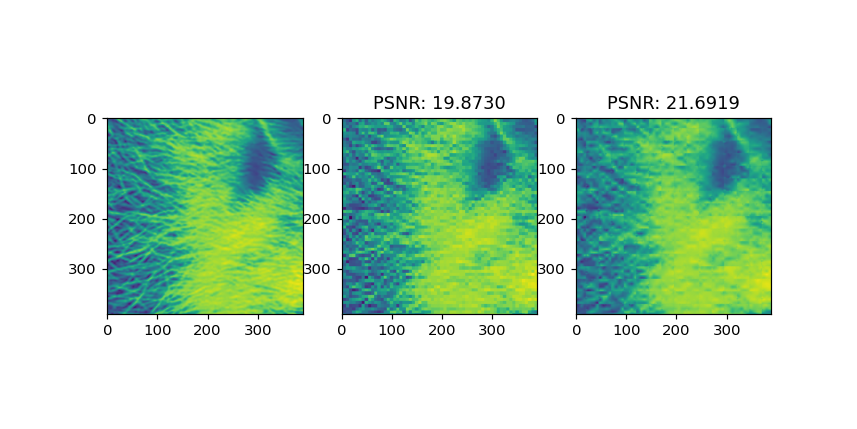

In [2430]:
tree = run_exp(2, 3, N=4, elim_sliver=5, parent_sum=False)